# Exploratory Data Analysis and Data Cleaning

In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

import scipy.stats as stats
from scipy.stats import mannwhitneyu, wilcoxon, kruskal, friedmanchisquare

In [2]:
data_path = r'data\Kaggle Binance Data'

In [3]:
all_files = os.listdir(data_path)
parquet_files = [file for file in all_files if file.endswith('.parquet')]

dataframes = {}

for file in parquet_files:
    df = pd.read_parquet(os.path.join(data_path, file))
    dataframes[file[:-8]] = df

In [4]:
# all of the dataframes are stored in a dictionary and cane be accessed like this:
dataframes['BTC-USDT'].head()

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
open_time,,,,,,,,,
2017-08-17 04:00:00,4261.479980,4261.479980,4261.479980,4261.479980,1.775183,7564.906738,3,0.075183,320.390839
2017-08-17 04:01:00,4261.479980,4261.479980,4261.479980,4261.479980,0.000000,0.000000,0,0.000000,0.000000
2017-08-17 04:02:00,4280.560059,4280.560059,4280.560059,4280.560059,0.261074,1117.542969,2,0.261074,1117.542969
2017-08-17 04:03:00,4261.479980,4261.479980,4261.479980,4261.479980,0.012008,51.171852,3,0.012008,51.171852
2017-08-17 04:04:00,4261.479980,4261.479980,4261.479980,4261.479980,0.140796,599.999329,1,0.140796,599.999329


In [5]:
# Creating a new dataframe with close prices for all the coins
earliest_timestamp = min(df.index.min() for df in dataframes.values())
latest_timestamp = max(df.index.max() for df in dataframes.values())

new_df = pd.DataFrame(index=pd.date_range(start=earliest_timestamp, end=latest_timestamp, freq='1T'))

for name, df in dataframes.items():
    df = df[['close']].rename(columns={'close': name}).astype('float64')
    new_df = new_df.join(df)

new_df.head()

,ADA-USDT,BNB-USDT,BTC-USDT,DOGE-USDT,DOT-USDT,ETH-USDT,LTC-USDT,MATIC-USDT,SOL-USDT,XRP-USDT
2017-08-17 04:00:00,NaN,NaN,4261.479980,NaN,NaN,301.130005,NaN,NaN,NaN,NaN
2017-08-17 04:01:00,NaN,NaN,4261.479980,NaN,NaN,301.130005,NaN,NaN,NaN,NaN
2017-08-17 04:02:00,NaN,NaN,4280.560059,NaN,NaN,300.000000,NaN,NaN,NaN,NaN
2017-08-17 04:03:00,NaN,NaN,4261.479980,NaN,NaN,300.000000,NaN,NaN,NaN,NaN
2017-08-17 04:04:00,NaN,NaN,4261.479980,NaN,NaN,301.130005,NaN,NaN,NaN,NaN


In [6]:
# count the number of missing values in each column
new_df.isnull().sum()

ADA-USDT       355733
BNB-USDT       146312
BTC-USDT        30098
DOGE-USDT      992756
DOT-USDT      1582228
ETH-USDT        30175
LTC-USDT       179170
MATIC-USDT     892798
SOL-USDT      1571069
XRP-USDT       380462
dtype: int64

### Visualizing data

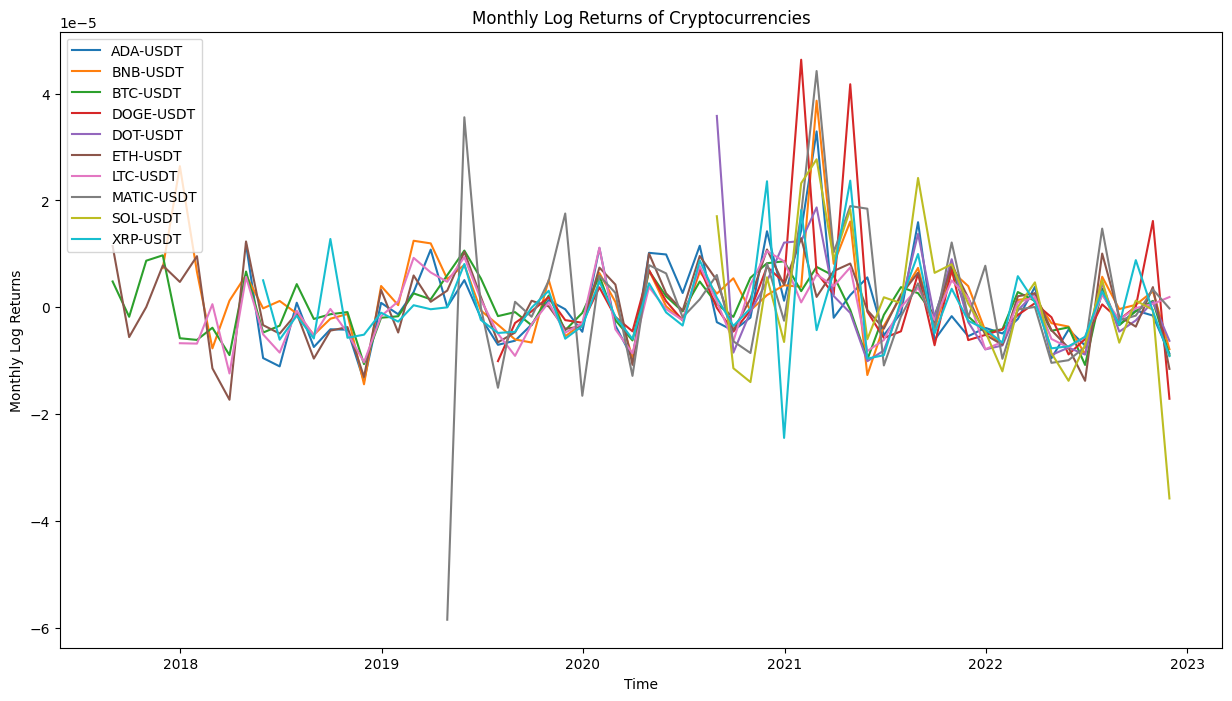

In [7]:
# Calculate log returns for each coin
log_returns_df = np.log(new_df / new_df.shift(1))

# Resample the log returns to 1 month
log_returns_df = log_returns_df.resample('1M').mean()

plt.figure(figsize=(15, 8))
for column in log_returns_df.columns:
    plt.plot(log_returns_df[column], label=column)

plt.title('Monthly Log Returns of Cryptocurrencies')
plt.xlabel('Time')
plt.ylabel('Monthly Log Returns')
plt.legend(loc='upper left')

plt.show()

Purely looking at the cryptocurrency monthly log returns it seems that they are very correlated. Let's look at daily log returns to see if this is still the case. In order for the plot to be more readable, we will only look at the data from 2021Q1 to 2021Q3 as we can see from the MATIC case that with it's inclusion in Binance the first fev months were very volatile, however with time the coin seems to have stabilized and adapted the same return pattern as the other coins.

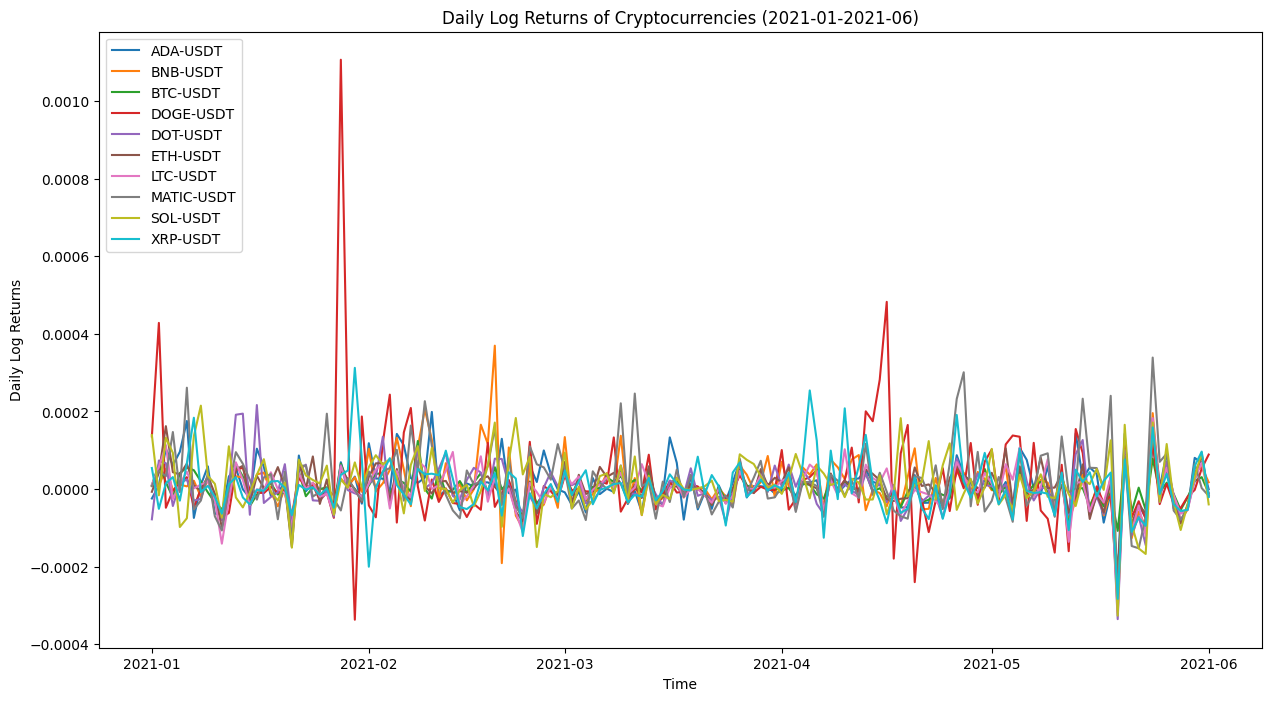

In [8]:
log_returns_df = np.log(new_df / new_df.shift(1))
log_returns_df = log_returns_df.resample('1D').mean()
log_returns_df = log_returns_df.loc['2021-01-01':'2021-06-01']

plt.figure(figsize=(15, 8))
for column in log_returns_df.columns:
    plt.plot(log_returns_df[column], label=column)

plt.title('Daily Log Returns of Cryptocurrencies (2021-01-2021-06)')
plt.xlabel('Time')
plt.ylabel('Daily Log Returns')
plt.legend(loc='upper left')

plt.show()

Even the daily log returns of the cryptocurrencies seem to be very closely correlated, but perhaps it just seems that way because of the scale of the plot. Let's look at the correlation matrix to see if this is the case.

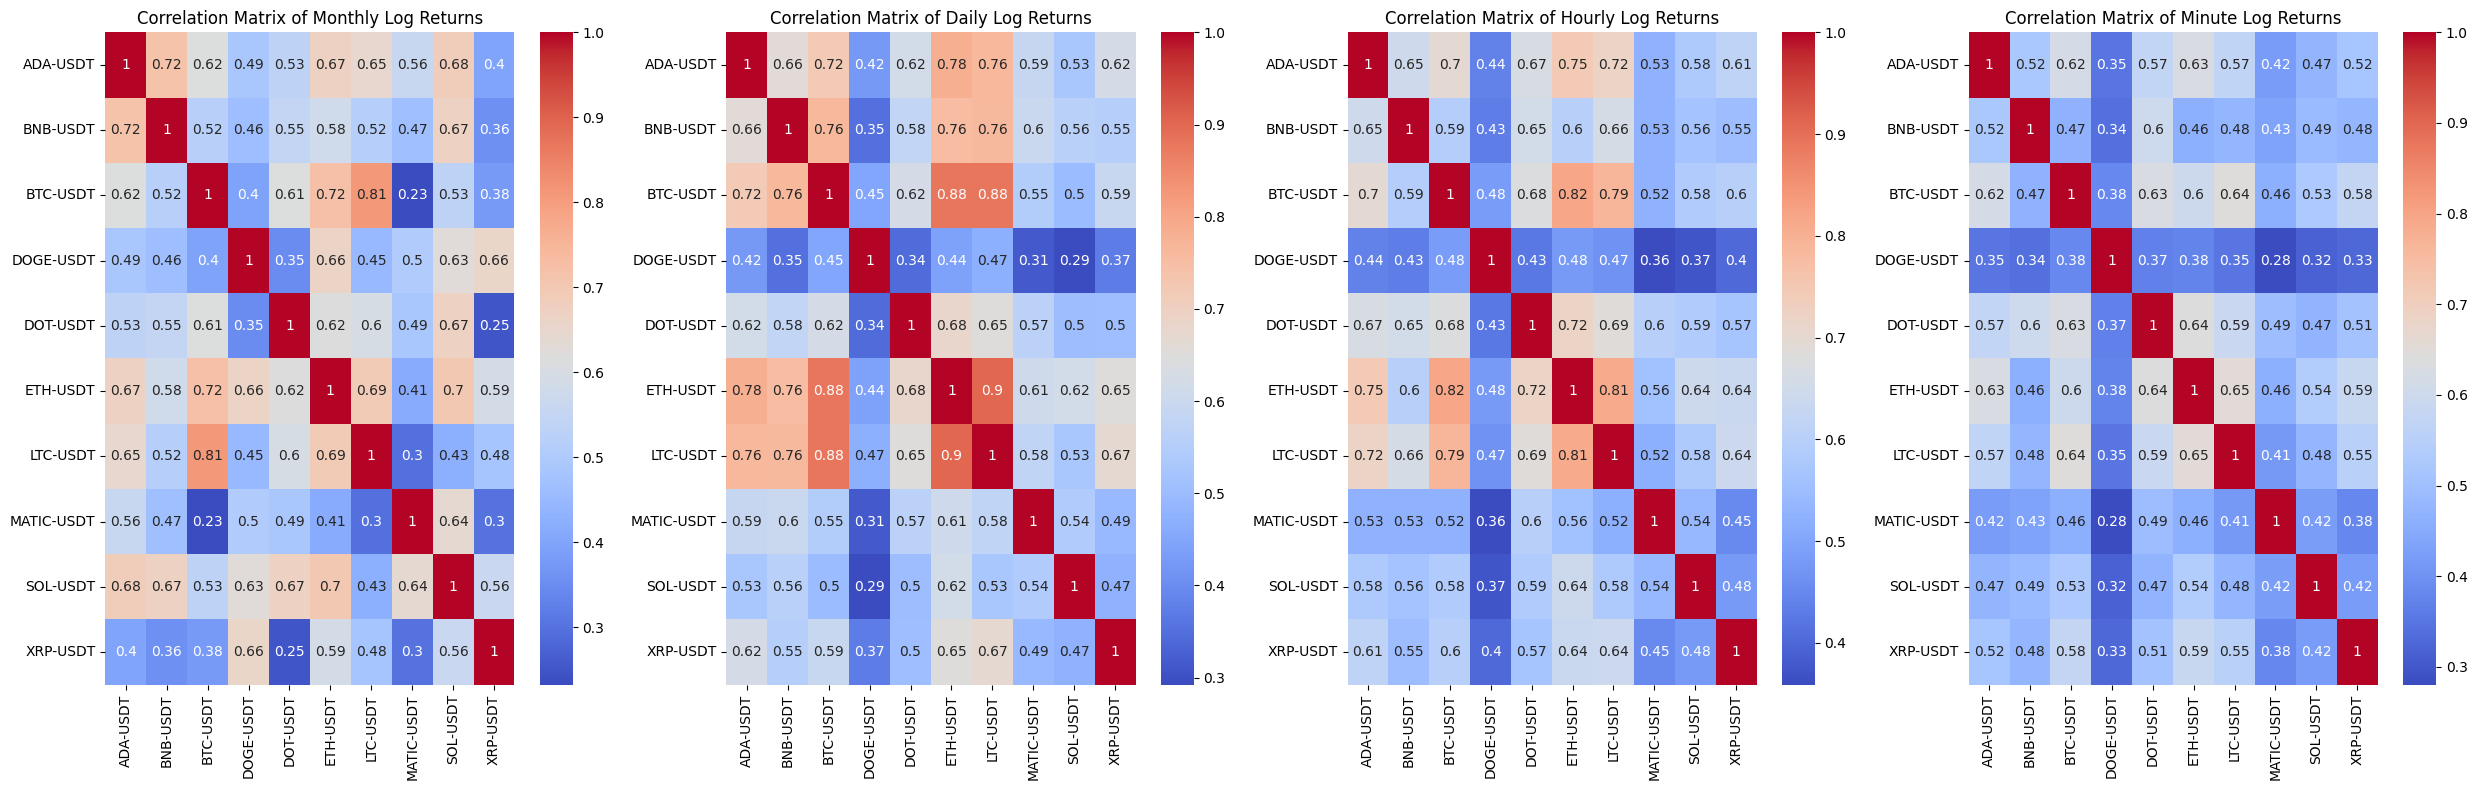

In [9]:
log_returns_df = np.log(new_df / new_df.shift(1))
fig, axes = plt.subplots(1, 4, figsize=(25, 8))
frequencies = ['1M', '1D', '1h', '1T']
titles = ['Monthly', 'Daily', 'Hourly', 'Minute']

for i, (freq, title) in enumerate(zip(frequencies, titles)):
    resampled_log_returns_df = log_returns_df.resample(freq).mean()
    sns.heatmap(resampled_log_returns_df.corr(), annot=True, cmap='coolwarm', ax=axes[i])
    axes[i].set_title(f'Correlation Matrix of {title} Log Returns')

plt.tight_layout()
plt.show()

Looking at the 4 correlation matrices we can see that the correlation between the cryptocurrencies is very high for *Monthly*, *Daily* and *Hourly* Log Returns. However, the correlation between the cryptocurrencies is *not as high for the 1 minute* log returns. This could be explained by the fact that there are a lot of NaN values in the data for some of the cryptocurrencies.
<br>
<br>
Interestingly, the correlation between the cryptocurrencies is the **highest for Daily Log Returns.** This could potentially indicate the possibility for statistical arbitrage between the cryptocurrencies in the 24 hour period. However, this is just a hypothesis and further analysis is required to confirm this.

### Further Data Cleaning
<br>
For simplicity we will simpli drop all of the missing values in the dataset. This is not an ideal solution, but it will work for our purposes.

In [10]:
# missing values as a percentage of the total number of values
new_df.isnull().sum() / new_df.shape[0] * 100

ADA-USDT      12.881036
BNB-USDT       5.297935
BTC-USDT       1.089844
DOGE-USDT     35.947539
DOT-USDT      57.292228
ETH-USDT       1.092632
LTC-USDT       6.487718
MATIC-USDT    32.328076
SOL-USDT      56.888162
XRP-USDT      13.776469
dtype: float64

In [11]:
print(len(new_df), 'total number of rows in the dataset before dropping NaNs')

2761680 total number of rows in the dataset before dropping NaNs


In [12]:
df_clean = new_df.dropna()
print(len(df_clean), 'total number of rows in the dataset after dropping NaNs')

1179435 total number of rows in the dataset after dropping NaNs


In [13]:
df_clean.describe()

,ADA-USDT,BNB-USDT,BTC-USDT,DOGE-USDT,DOT-USDT,ETH-USDT,LTC-USDT,MATIC-USDT,SOL-USDT,XRP-USDT
count,1.179435e+06,1.179435e+06,1.179435e+06,1.179435e+06,1.179435e+06,1.179435e+06,1.179435e+06,1.179435e+06,1.179435e+06,1.179435e+06
mean,9.567335e-01,3.024246e+02,3.516491e+04,1.302635e-01,1.855906e+01,2.127085e+03,1.252032e+02,9.140603e-01,6.116587e+01,6.467935e-01
std,6.912621e-01,1.735631e+02,1.515583e+04,1.142979e-01,1.262540e+01,1.160741e+03,6.667905e+01,6.867126e-01,6.263437e+01,3.371642e-01
min,7.558000e-02,1.802750e+01,9.881820e+03,2.451900e-03,2.640000e+00,3.114700e+02,4.040000e+01,1.171000e-02,1.059200e+00,1.736100e-01
25%,4.218000e-01,2.261000e+02,2.051367e+04,5.600000e-02,6.910000e+00,1.293690e+03,6.013000e+01,3.162850e-01,1.413000e+01,3.612000e-01
50%,8.957800e-01,3.081100e+02,3.653465e+04,8.788000e-02,1.690580e+01,1.955630e+03,1.216400e+02,8.846000e-01,3.571500e+01,5.840700e-01
75%,1.347220e+00,4.157000e+02,4.708632e+04,2.045000e-01,2.794700e+01,3.032650e+03,1.727000e+02,1.455065e+00,9.501000e+01,8.430000e-01
max,3.099000e+00,6.910600e+02,6.900000e+04,7.380500e-01,5.503000e+01,4.865220e+03,4.127500e+02,2.920000e+00,2.598000e+02,1.964710e+00


### Changing Data Granularity
<br>
We will now change the data granularity from 1 minute to 1 day. This is done by taking the mean of the log returns for each hour. This is done in order to reduce computing time and to make the data more manageable and analysis easier.

In [14]:
# resample the data to 1D frequency
df_1D = df_clean.resample('1D').mean()
df_1D.head()

,ADA-USDT,BNB-USDT,BTC-USDT,DOGE-USDT,DOT-USDT,ETH-USDT,LTC-USDT,MATIC-USDT,SOL-USDT,XRP-USDT
2020-08-18,0.136974,23.042320,11999.721501,0.003508,3.042987,423.350500,65.873334,0.027032,3.365193,0.302762
2020-08-19,0.132246,22.533322,11792.486702,0.003427,2.980909,411.080167,62.619188,0.025865,3.061063,0.292455
2020-08-20,0.130440,22.694967,11791.459972,0.003442,2.857648,411.209271,62.518167,0.025910,3.140603,0.290325
2020-08-21,0.129318,22.650816,11742.076479,0.003450,2.916490,405.831743,61.495264,0.026950,3.074459,0.287515
2020-08-22,0.123318,21.944287,11557.337387,0.003393,3.608743,389.313125,59.388590,0.025330,2.938178,0.279879


In [15]:
# save df_1D to a csv file
# df_1D.to_csv(r'data\Kaggle Binance Data\cleaned_data\df_1D.csv')

### Creating new datasets with different price metrics

In [16]:
# price difference dataframe
df_diff = df_1D - df_1D.shift(1)
df_diff = df_diff.iloc[1:]
df_diff.head()

,ADA-USDT,BNB-USDT,BTC-USDT,DOGE-USDT,DOT-USDT,ETH-USDT,LTC-USDT,MATIC-USDT,SOL-USDT,XRP-USDT
2020-08-19,-0.004729,-0.508998,-207.234798,-0.000081,-0.062078,-12.270333,-3.254146,-0.001167,-0.304130,-0.010307
2020-08-20,-0.001806,0.161645,-1.026731,0.000015,-0.123261,0.129104,-0.101021,0.000045,0.079540,-0.002129
2020-08-21,-0.001122,-0.044151,-49.383493,0.000009,0.058842,-5.377528,-1.022903,0.001040,-0.066143,-0.002810
2020-08-22,-0.006000,-0.706528,-184.739092,-0.000057,0.692253,-16.518618,-2.106674,-0.001620,-0.136282,-0.007636
2020-08-23,-0.000893,-0.066631,59.640244,0.000019,0.414408,1.247007,0.139285,0.000034,0.222505,0.003047


In [17]:
# save df_diff to a csv file
# df_diff.to_csv(r'data\Kaggle Binance Data\cleaned_data\df_diff.csv')

In [18]:
# log returns dataframe
df_log_returns = np.log(df_1D / df_1D.shift(1))
df_log_returns = df_log_returns.iloc[1:]
df_log_returns.head()

,ADA-USDT,BNB-USDT,BTC-USDT,DOGE-USDT,DOT-USDT,ETH-USDT,LTC-USDT,MATIC-USDT,SOL-USDT,XRP-USDT
2020-08-19,-0.035132,-0.022337,-0.017421,-0.023328,-0.020611,-0.029412,-0.050662,-0.044136,-0.094723,-0.034637
2020-08-20,-0.013751,0.007148,-0.000087,0.004331,-0.042229,0.000314,-0.001615,0.001722,0.025653,-0.007308
2020-08-21,-0.008638,-0.001947,-0.004197,0.002504,0.020382,-0.013164,-0.016497,0.039349,-0.021286,-0.009727
2020-08-22,-0.047507,-0.031689,-0.015858,-0.016613,0.212979,-0.041555,-0.034858,-0.061984,-0.045340,-0.026916
2020-08-23,-0.007268,-0.003041,0.005147,0.005658,0.108706,0.003198,0.002343,0.001359,0.072998,0.010828


In [19]:
# save df_log_returns to a csv file
# df_log_returns.to_csv(r'data\Kaggle Binance Data\cleaned_data\df_log_returns.csv')

In [20]:
# cumulative log returns dataframe
df_cum_log_returns = (df_log_returns + 1).cumprod()
df_cum_log_returns.iloc[0] = 1
df_cum_log_returns.head()

,ADA-USDT,BNB-USDT,BTC-USDT,DOGE-USDT,DOT-USDT,ETH-USDT,LTC-USDT,MATIC-USDT,SOL-USDT,XRP-USDT
2020-08-19,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-08-20,0.951601,0.984651,0.982494,0.980903,0.938030,0.970893,0.947805,0.957510,0.928499,0.958308
2020-08-21,0.943381,0.982734,0.978370,0.983359,0.957149,0.958112,0.932169,0.995187,0.908736,0.948987
2020-08-22,0.898565,0.951592,0.962855,0.967023,1.161001,0.918298,0.899676,0.933501,0.867534,0.923443
2020-08-23,0.892034,0.948698,0.967811,0.972494,1.287208,0.921235,0.901783,0.934770,0.930863,0.933443


In [21]:
# save df_cum_log_returns to a csv file
# df_cum_log_returns.to_csv(r'data\Kaggle Binance Data\cleaned_data\df_cum_log_returns.csv')

## Exploratory Data Analysis

**Cumulative Returns**

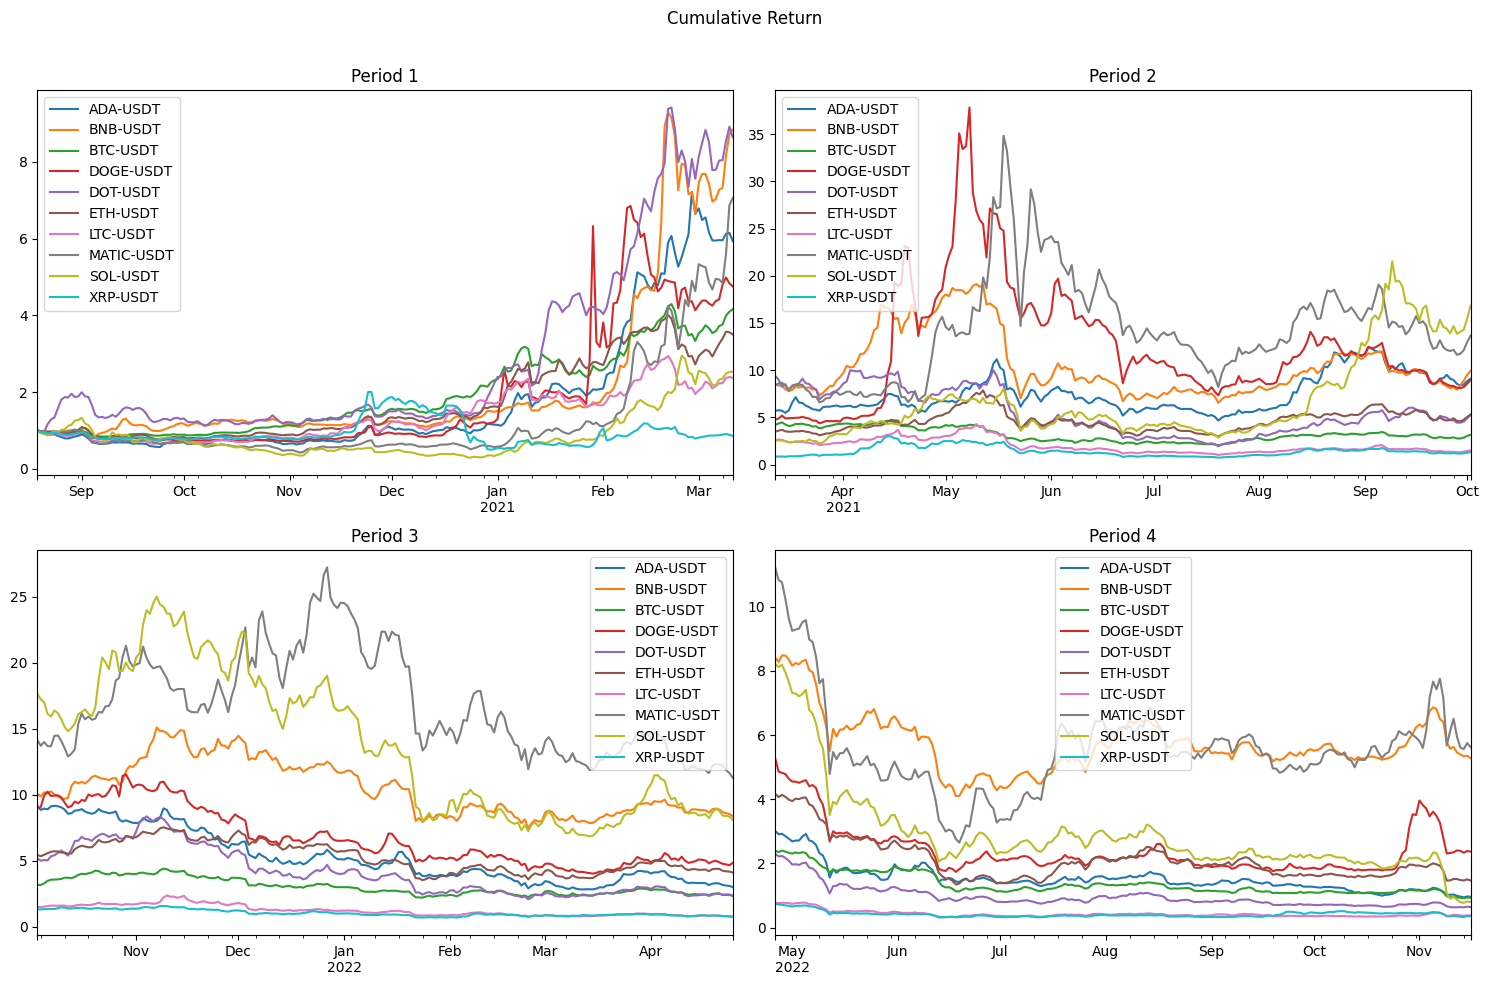

In [22]:
total_rows = len(df_cum_log_returns)
rows_per_plot = total_rows // 4

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Cumulative Return')
flat_axes = axes.flatten()

for i in range(4):
    start = i * rows_per_plot
    end = (i + 1) * rows_per_plot if i < 3 else total_rows
    df_cum_log_returns.iloc[start:end].plot(ax=flat_axes[i], title=f'Period {i + 1}')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

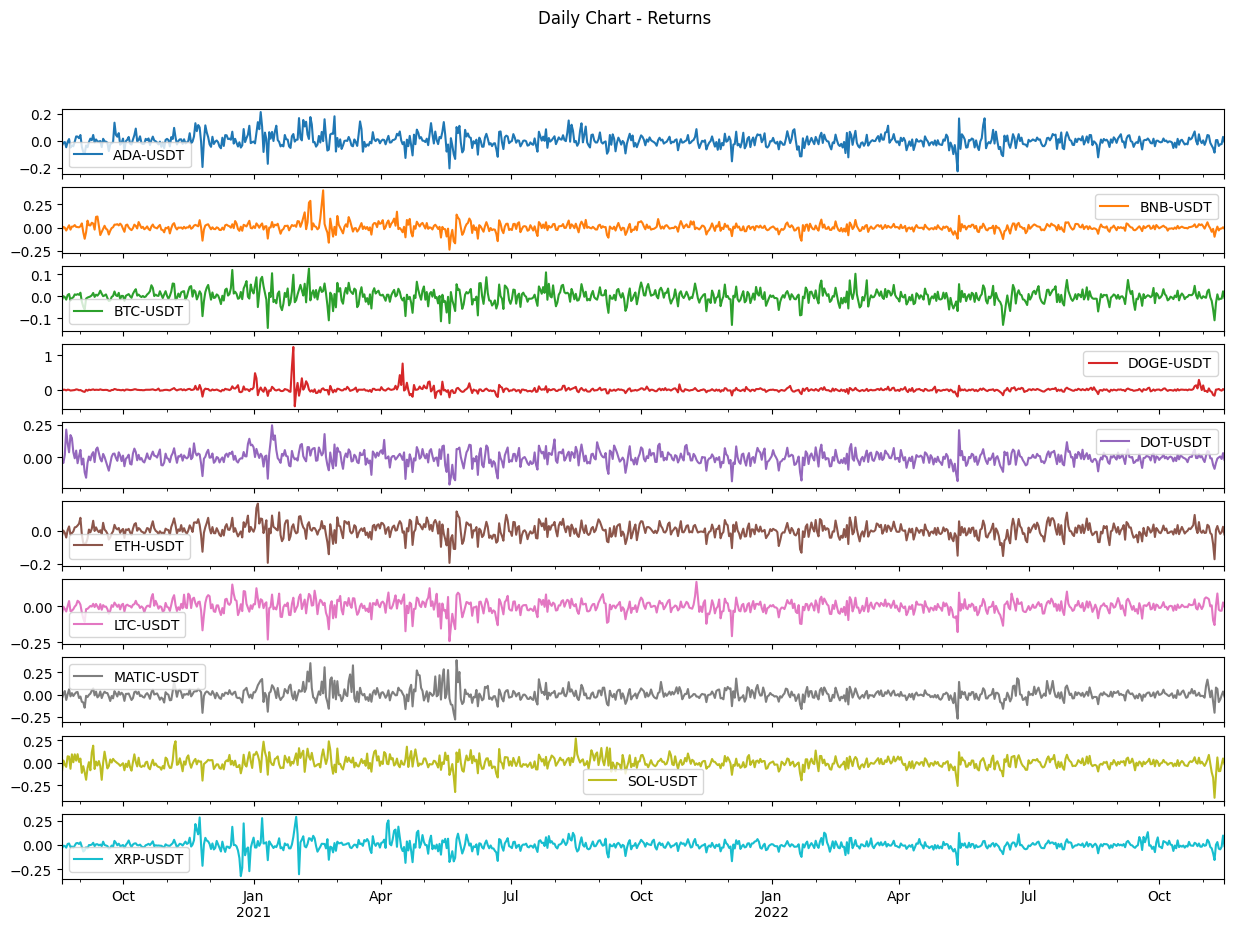

In [23]:
df_log_returns.plot(subplots=True, figsize=(15,10),title='Daily Chart - Returns')

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

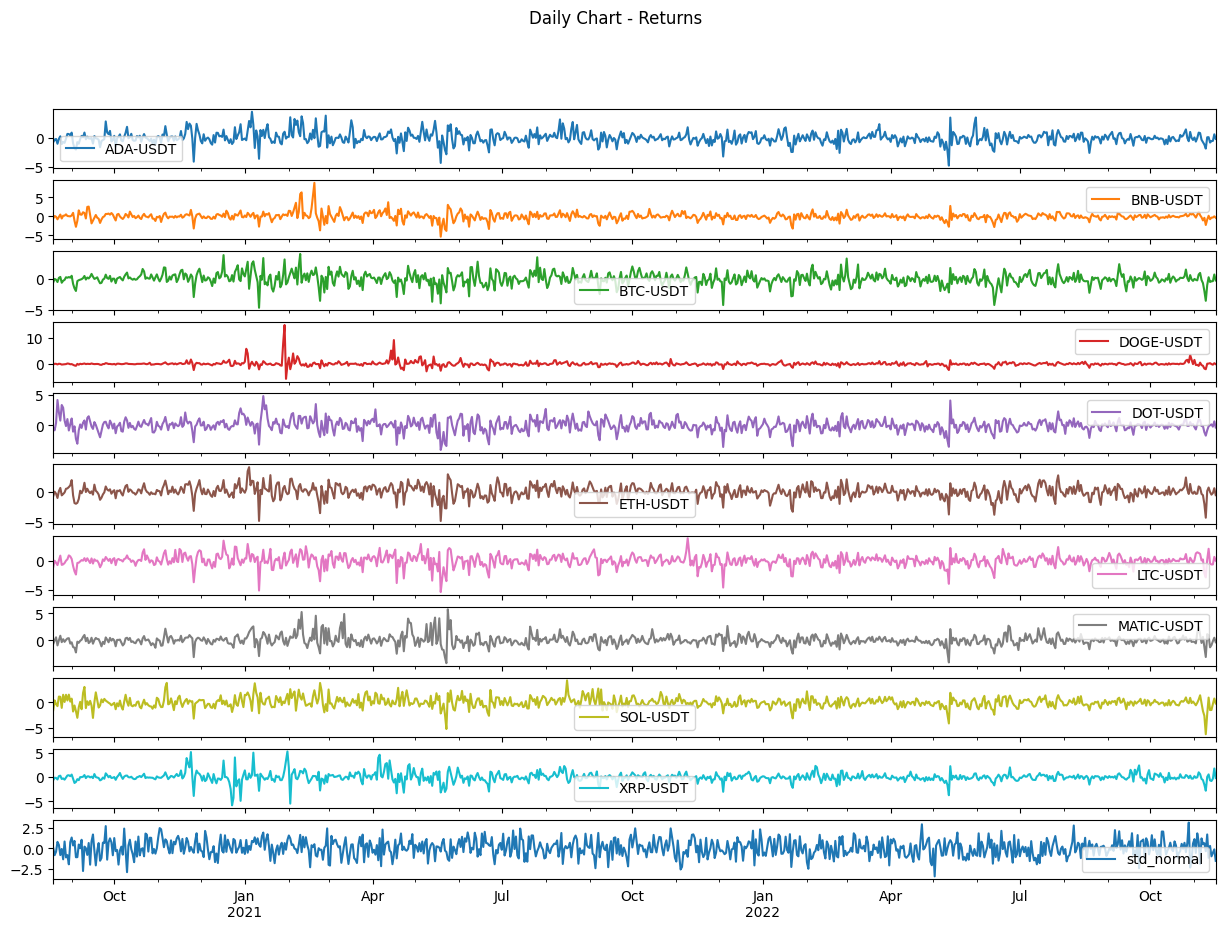

In [24]:
df_std = df_log_returns.apply(lambda x: (x - np.mean(x))/np.std(x))
df_std['std_normal'] = np.random.standard_normal(len(df_std.index))
df_std.dropna().plot(subplots=True, figsize=(15,10),title='Daily Chart - Returns')

<Axes: title={'center': 'Density Graph - Returns'}, ylabel='Density'>

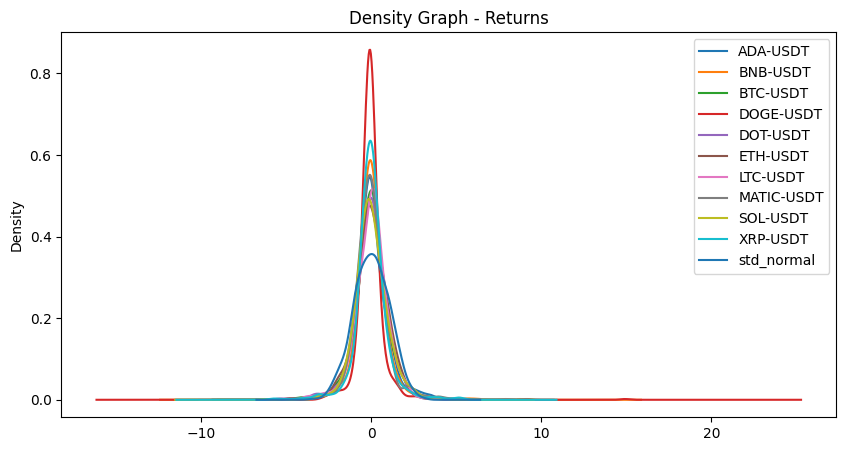

In [25]:
df_std.plot(kind='density',figsize=(10,5), title='Density Graph - Returns')

In [26]:
# TODO: add to utils class
def advaced_describe(df, alpha=0.05):
    '''
    pandas describe with kurtosis and skewness
    parameters
    ---------
    alpha = significance level for normality test
    normality test based on D'Agostino and Pearson's  test that combines skew and kurtosis to produce an omnibus test of normality.'
    '''
    df_ = df.dropna()
    df_des = df_.describe().round(5)
    des = stats.describe(df_)
    df_des.loc['skew'] = des.skewness
    df_des.loc['kurt'] = des.kurtosis
    pvals = np.round(stats.normaltest(df_)[1] > alpha, decimals=0)
    df_des.loc['normal?'] = ['Yes' if x == True else "No" for x in pvals]
    print('normality test based on D\'Agostino and Pearson\'s  test that combines skewness and kurtosis to produce an omnibus test of normality. ')
    return df_des

In [27]:
advaced_describe(df_log_returns, alpha=0.01)

normality test based on D'Agostino and Pearson's  test that combines skewness and kurtosis to produce an omnibus test of normality. 


,ADA-USDT,BNB-USDT,BTC-USDT,DOGE-USDT,DOT-USDT,ETH-USDT,LTC-USDT,MATIC-USDT,SOL-USDT,XRP-USDT
count,820.0,820.0,820.0,820.0,820.0,820.0,820.0,820.0,820.0,820.0
mean,0.00109,0.00302,0.0004,0.00391,0.00079,0.0013,-0.00015,0.0043,0.00176,0.00027
std,0.04774,0.04504,0.03115,0.08335,0.05147,0.04045,0.04448,0.06735,0.06302,0.05469
min,-0.22575,-0.23715,-0.14497,-0.47816,-0.20718,-0.19447,-0.24205,-0.28373,-0.39156,-0.32
25%,-0.02446,-0.01629,-0.01449,-0.02155,-0.02774,-0.01824,-0.02243,-0.03137,-0.03297,-0.02148
50%,-0.00149,0.00211,0.00125,-0.00123,0.00085,0.00152,0.00236,-0.00003,-0.00099,-0.00108
75%,0.02307,0.02226,0.01724,0.01853,0.02932,0.02599,0.02302,0.03163,0.03497,0.01985
max,0.21305,0.39897,0.12528,1.24652,0.24601,0.16319,0.17157,0.38953,0.27215,0.29058
skew,0.275229,1.163914,-0.30581,5.917634,-0.009049,-0.542538,-0.83209,1.008273,-0.158331,0.037736
kurt,3.055763,13.133015,2.784158,76.186372,2.477382,2.441333,3.825181,5.503387,3.988956,8.2036


In [28]:
advaced_describe(df_std, alpha=0.01)

normality test based on D'Agostino and Pearson's  test that combines skewness and kurtosis to produce an omnibus test of normality. 


,ADA-USDT,BNB-USDT,BTC-USDT,DOGE-USDT,DOT-USDT,ETH-USDT,LTC-USDT,MATIC-USDT,SOL-USDT,XRP-USDT,std_normal
count,820.0,820.0,820.0,820.0,820.0,820.0,820.0,820.0,820.0,820.0,820.0
mean,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.02872
std,1.00061,1.00061,1.00061,1.00061,1.00061,1.00061,1.00061,1.00061,1.00061,1.00061,1.04
min,-4.75498,-5.33523,-4.66983,-5.78732,-4.0434,-4.84311,-5.44222,-4.27935,-6.24459,-5.85919,-3.45074
25%,-0.53564,-0.42897,-0.4785,-0.30563,-0.55464,-0.48346,-0.5012,-0.52996,-0.55128,-0.39794,-0.67402
50%,-0.05413,-0.02014,0.02709,-0.0617,0.00112,0.00541,0.0566,-0.06432,-0.04354,-0.02477,0.02218
75%,0.46068,0.42751,0.54098,0.17549,0.55469,0.61073,0.52135,0.40605,0.52727,0.35824,0.76664
max,4.44302,8.7958,4.01121,14.91793,4.76774,4.00506,3.86344,5.7236,4.29298,5.3111,3.12312
skew,0.275229,1.163914,-0.30581,5.917634,-0.009049,-0.542538,-0.83209,1.008273,-0.158331,0.037736,-0.049254
kurt,3.055763,13.133015,2.784158,76.186372,2.477382,2.441333,3.825181,5.503387,3.988956,8.2036,-0.170238


array([[<Axes: xlabel='ADA-USDT', ylabel='ADA-USDT'>,
        <Axes: xlabel='BNB-USDT', ylabel='ADA-USDT'>,
        <Axes: xlabel='BTC-USDT', ylabel='ADA-USDT'>,
        <Axes: xlabel='DOGE-USDT', ylabel='ADA-USDT'>,
        <Axes: xlabel='DOT-USDT', ylabel='ADA-USDT'>,
        <Axes: xlabel='ETH-USDT', ylabel='ADA-USDT'>,
        <Axes: xlabel='LTC-USDT', ylabel='ADA-USDT'>,
        <Axes: xlabel='MATIC-USDT', ylabel='ADA-USDT'>,
        <Axes: xlabel='SOL-USDT', ylabel='ADA-USDT'>,
        <Axes: xlabel='XRP-USDT', ylabel='ADA-USDT'>,
        <Axes: xlabel='std_normal', ylabel='ADA-USDT'>],
       [<Axes: xlabel='ADA-USDT', ylabel='BNB-USDT'>,
        <Axes: xlabel='BNB-USDT', ylabel='BNB-USDT'>,
        <Axes: xlabel='BTC-USDT', ylabel='BNB-USDT'>,
        <Axes: xlabel='DOGE-USDT', ylabel='BNB-USDT'>,
        <Axes: xlabel='DOT-USDT', ylabel='BNB-USDT'>,
        <Axes: xlabel='ETH-USDT', ylabel='BNB-USDT'>,
        <Axes: xlabel='LTC-USDT', ylabel='BNB-USDT'>,
        <Axes: xlabel

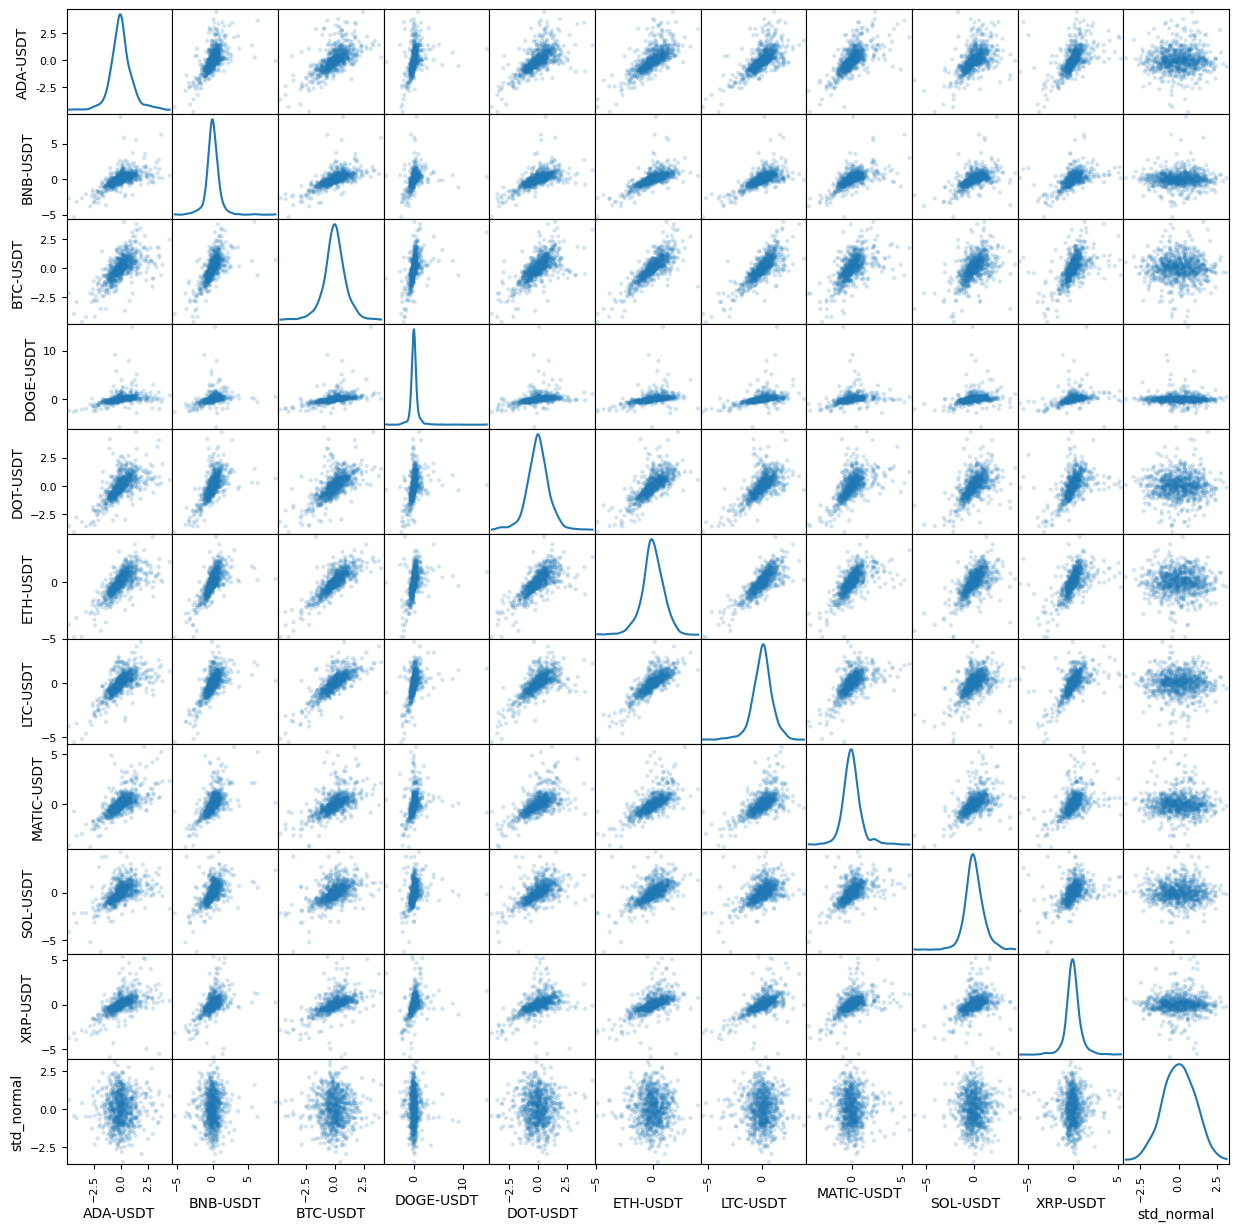

In [29]:
scatter_matrix(df_std, alpha=0.2, figsize=(15, 15), diagonal='kde')

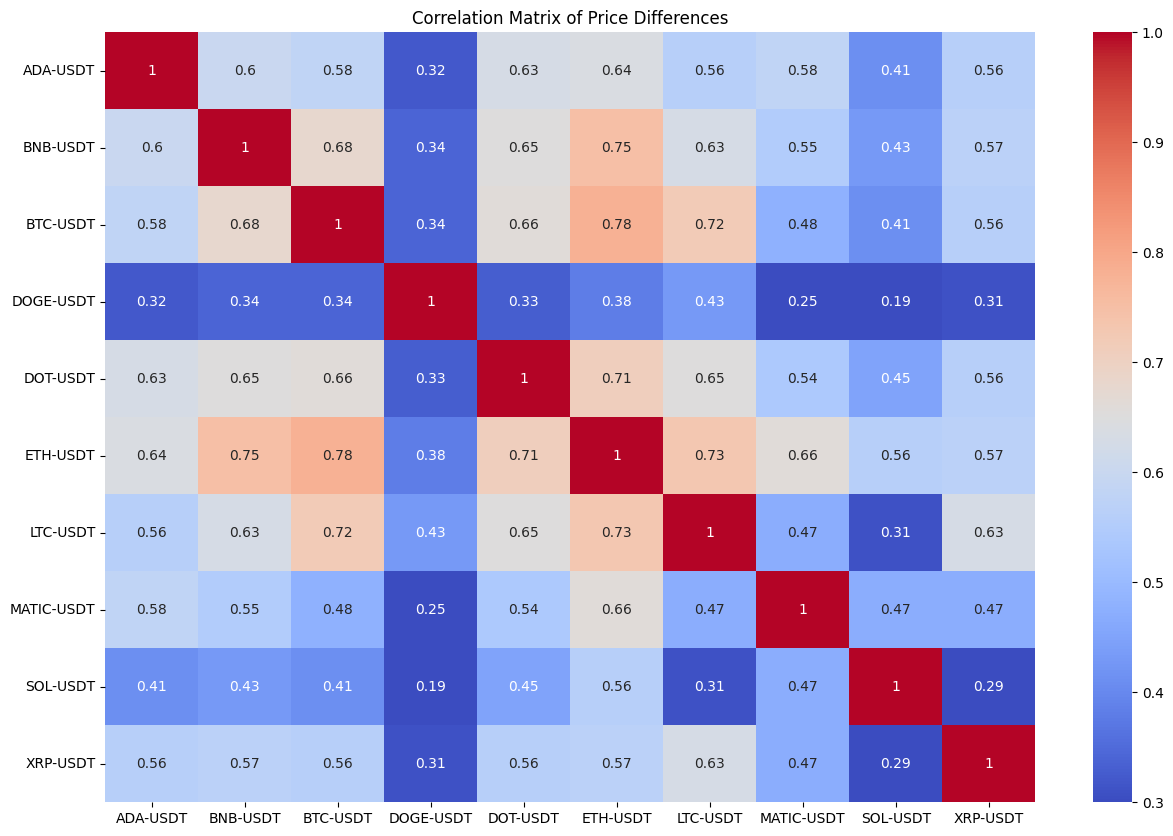

In [30]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_diff.corr().round(2), annot=True, cmap='coolwarm', vmin=0.3, vmax=1)
plt.title('Correlation Matrix of Price Differences')
plt.show()